#Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](http://www.eyrignoux.com.fr/coursIA/deepLearning/example-facial-keypoints.png)

##Load and preprocess data

In [391]:
!wget http://www.eyrignoux.com.fr/coursIA/deepLearning/facial-keypoints-data.zip
!unzip facial-keypoints-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/images/03402.jpg   
  inflating: data/images/03284.jpg   
  inflating: data/images/03163.jpg   
  inflating: data/images/03156.jpg   
  inflating: data/images/03120.jpg   
  inflating: data/images/03088.jpg   
  inflating: data/images/03064.jpg   
  inflating: data/images/03046.jpg   
  inflating: data/images/03032.jpg   
  inflating: data/images/02993.jpg   
  inflating: data/images/02939.jpg   
  inflating: data/images/02907.jpg   
  inflating: data/images/02897.jpg   
  inflating: data/images/02884.jpg   
  inflating: data/images/02811.jpg   
  inflating: data/images/02807.jpg   
  inflating: data/images/02801.jpg   
  inflating: data/images/02700.jpg   
  inflating: data/images/02667.jpg   
  inflating: data/images/02568.jpg   
  inflating: data/images/02521.jpg   
  inflating: data/images/02515.jpg   
  inflating: data/images/02510.jpg   
  inflating: data/images/02465.jpg   
  inflating: data/images/05745.jpg   

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [392]:
import pandas as pd
from os.path import isfile, join

df = pd.read_csv(join('data', 'gt.csv'))

In [625]:
import cv2
from skimage.color import gray2rgb
from skimage.transform import resize
from skimage.io import imread
from skimage.io import imshow

img_size = 100

def read_image_and_keypoints(filename):
    img = imread(join('data/images', filename))
    
    if len(img.shape) == 2:
        img = gray2rgb(img)
    img_resized = resize(img, (img_size, img_size))
    
    key_points = df[df['filename'] == filename].copy()
    
    coords_x = (img_resized.shape[0]) - 0,5
    key_points.update(coords_x)

    coords_y = (img_resized.shape[1]) - 0,5
    key_points.update(coords_y)
    
    points = key_points.drop('filename', axis=1).values[0]
    
    return img_resized, points


##Visualize data
Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

In [632]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from matplotlib.patches import Circle

def visualize_points(img, points):
    
    fig,ax = plt.subplots(1)
    ax.set_aspect('equal')
    ax.imshow(img)
    
    for i in range(0, len(points), 2):
        x = (points[i] + 0.5)
        y = (points[i + 1] + 0.5)

        cmap = cm.get_cmap('Spectral')
        rgba_color = cmap(i/len(points))

        circ = Circle((x, y), radius=1, color=rgba_color)
        ax.add_patch(circ)

    plt.show()

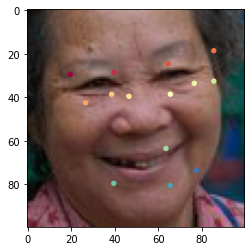

In [633]:
filename_test = df['filename'].sample(1).values[0]
img_test, keypoints_test = read_image_and_keypoints(filename_test)
visualize_points(img_test, keypoints_test)

##Simple data augmentation
For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

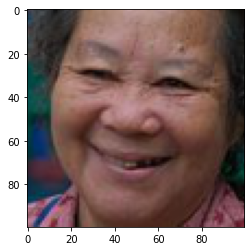

In [634]:

import numpy as np

def flip_point(f_points, points, nb_1, nb_2 ):
    x_1 = nb_1*2
    y_1 = nb_1*2+1
    x_2 = nb_2*2
    y_2 = nb_2*2+1
    
    # Flipping is easy, because the X axis is centered at the middle of the image: we just have to put a negative sign
    f_points[x_1]=-points[x_2]
    f_points[y_1]=points[y_2]
    f_points[x_2]=-points[x_1]
    f_points[y_2]=points[y_1]

def flip_img(img, points):
    # Write your code for flipping here
    f_img = np.fliplr(img)
    
    # For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates 
    # and swap corresponding points on the left and right sides of the face)
    # When you flip the image you have to swap the following points (indexed from 1 to 14)
    # 1,4 | 2,3 | 5,10 | 6,9 | 7,8 | 11,11 | 12,14 | 13,13
    f_points = np.copy(points)
    flip_point(f_points, points, 0, 3)
    flip_point(f_points, points, 1, 2)
    flip_point(f_points, points, 4, 9)
    flip_point(f_points, points, 5, 8)
    flip_point(f_points, points, 6, 7)
    flip_point(f_points, points, 10, 10)
    flip_point(f_points, points, 11, 13)
    flip_point(f_points, points, 12, 12)
    
    return (f_img, f_points)
    #pass

f_img, f_points = flip_img(img_test, keypoints_test)
visualize_points(f_img, f_points)

##Split the data in training set and test set

In [638]:
from sklearn.model_selection import train_test_split

tr_files, te_files = ## YOUR CODE HERE split the filenames contained in df['filename'] in 2 sets


SyntaxError: ignored

##Solve a problem of memory
If we try to store all the images and keypoints in memory, we will get an OutOfMemory error.
Therefore, we program a generator that Keras will use in order to iterate over the dataset.

In [ ]:
from itertools import chain
from itertools import islice

# batch generator
BATCH_SIZE = 32
#BATCH_SIZE = 16

def batch_generator(filenames, batch_size):
    """
    Implement batch generator that yields items in batches of size batch_size.
    There's no need to shuffle input items, just chop them into batches.
    Remember about the last batch that can be smaller than batch_size!
    Input: any iterable (list, generator, ...). You should do `for item in items: ...`
        In case of generator you can pass through your items only once!
    Output: In output yield each batch as a list of items.
    """
    
    # https://stackoverflow.com/questions/24527006/split-a-generator-into-chunks-without-pre-walking-it
    iterator = iter(filenames)
    for first in iterator:        
        yield list(chain([first], islice(iterator, batch_size - 1)))

In [ ]:
import numpy as np
import random

def train_generator(files):
    while True:  # so that Keras can loop through this as long as it wants
        for batch in batch_generator(files, BATCH_SIZE):
            # prepare batch images
            batch_imgs = []
            batch_targets = []
            for filename in batch:
                img, keypoints = ## YOUR CODE HERE read the image 'filename' and its keypoints
                ## YOUR CODE HERE: randomly flip the image and its keypoints, by 50% chance
                batch_imgs.append(img)
                batch_targets.append(keypoints)
            # stack images into 4D tensor [batch_size, img_size, img_size, 3]
            batch_imgs = ## YOUR CODE HERE hint: you can use np.stack()
            # convert targets into 2D tensor [batch_size, num_classes]
            batch_targets = ## YOUR CODE HERE: again, you can use np.stack()
            yield batch_imgs, batch_targets

In [ ]:
# test training generator
for imgs, keypoints in train_generator(tr_files):
    for img, keypoint in zip(imgs, keypoints):
      visualize_points(img, keypoint)
    break

##Network architecture

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [ ]:

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, InputLayer, LeakyReLU, Dropout

# See https://fairyonice.github.io/Achieving-top-5-in-Kaggles-facial-keypoints-detection-using-FCN.html
# And https://fairyonice.github.io/achieving-top-23-in-kaggles-facial-keypoints-detection-with-keras-tensorflow.html
model = keras.models.Sequential()
# Define here your model

## YOUR CODE HERE: conv2d layer, filters=32, kernel_size=3, padding="same", activation='relu', YOU HAVE TO SET CORRECTLY THE input_shape (size of the images)
## YOUR CODE HERE: MaxPooling2D layer, pool_size = (2,2)
## YOUR CODE HERE: conv2d layer, filters=64, kernel_size=2, padding="same", activation='relu'
## YOUR CODE HERE: maxPooling2d layer, pool_size = (2,2)
## YOUR CODE HERE: conv2d layer, filters=128, kernel_size=2, padding="same", activation='relu'
## YOUR CODE HERE: maxpooling2d layer, pool_size = (2,2)

## YOUR CODE HERE: which layer is mandatory before the first dense layer ?
## YOUR CODE HERE: dense layer, 500 neurons, activation='relu'
## YOUR CODE HERE: dropout layer, 25% probability
## YOUR CODE HERE: dense layer, 500 neurons, activation='relu'
## YOUR CODE HERE: dropout layer, 25% probability
## YOUR CODE HERE: dense layer, 28 neurons. As we want to predict a continuous value (the coordinates of keypoints), we want to run a regression, not a classification.
## Therefore, which activation function do we need on that layer ?
    

##Network training
Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [ ]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras import backend


def r2_keras(y_true, y_pred):
    ## YOUR CODE HERE: as we are running a regression, we want to evaluate its results according to the r2 metric.
    ## NEVER FORGET THAT accuracy, F1 score... are meaningful only for classification; they are completely irrelevant to regression.
    ## Despite that, you will find often wrong examples of code on stackoverflow and other sites, because people are
    ## used to use the classification metrics, and they forget about their meaning
    ## See https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/discussion/34019 for the code that you have to write

model.compile(
    loss='mean_squared_error',
    optimizer=Adam(),
    metrics=[r2_keras]  # report r2 during training 
    # - commented for saving the model (otherwise load raises an error: "ValueError: Unknown metric function:r2_keras")
)


In [ ]:

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')

## YOUR CODE HERE: call fit_generator in order to train your CNN.
## Hint: you implemented a generator in train_generator. You have to use it for the training set (tr_files)
## and for the test set (te_files)
## steps_per_epoch=len(tr_files) * 2 // BATCH_SIZE // 8,
## epochs=2 * 8
## validation_steps=len(te_files) // BATCH_SIZE // 4,
## Use earlyStopping as a callback function
## verbose=1


Epoch 1/16


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


18/18 [==============================] - 62s 3s/step - loss: 0.0068 - r2_keras: 0.8184 - val_loss: 0.0037 - val_r2_keras: 0.9016
Epoch 2/16
18/18 [==============================] - 51s 3s/step - loss: 0.0049 - r2_keras: 0.8680 - val_loss: 0.0032 - val_r2_keras: 0.9159
Epoch 3/16
18/18 [==============================] - 52s 3s/step - loss: 0.0045 - r2_keras: 0.8794 - val_loss: 0.0032 - val_r2_keras: 0.9146
Epoch 4/16
18/18 [==============================] - 51s 3s/step - loss: 0.0037 - r2_keras: 0.9014 - val_loss: 0.0033 - val_r2_keras: 0.9144


### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

In [ ]:
filenames = te_files.sample(10).values
# Example of output, for 10 files chosen randomly in the test set
img_test = np.array([read_image_and_keypoints(filename)[0] for filename in filenames])

y_pred_test = ## YOUR CODE HERE: predict the keypoints for the images in img_test
for img, pred in zip(img_test, y_pred_test):
    visualize_points(img, pred)